# CAB420, Clustering, Example 4: Clustering Applications
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

In this example we'll look at two example clustering applications:
* Segmentation / Knowledge Discovery
* Anomaly Detection

In this example we're using some data from the New York Citibike service (more data can be found [here](https://www.citibikenyc.com/system-data)). We'll use data from three months:
* July, 2019
* December, 2019
* July, 2020

Note that with clustering, we don't always have the same training, validation and testing splits that we do for supervised models. This is due to the fact that we don't have labels, and so evaluating overfitting is much more challenging (if at all possible).

### Segmentation / Knowledge Discovery

This is a common task when we have a large dataset with no labels. Often in such situations we seek to understand what is present in the data by grouping related items. This also aids visualisation, and can also help simplify the data by reducing a large dataset to a few representitive examples (i.e. cluster centres).

In this task, we'll use the first two sets (July and December '19) to train our clustering models. We'll then use these models to see if there is a difference in bike usage between July '19, Decmeber '19 and July '20. 

### Anomaly Detection

This task involves finding points that are unusual, or abnormal. A typical process for this is:
* Train the model on a batch of normal data
* For a new point, determine if it's fit the trained model. If it doesn't, then the point is abnormal

Again we'll use the first two sets (July and December '19) to train our clustering models. We'll then look for abnormalities in the July '20 data. Note that this therefore assumes that the July and December '19 data does not contain any abnormal points, which is probably not the case, though at least we can reasonably expect them to be very scarce.

### Runtime Warning

Finally, a quick warning that due to the size of these datasets the two blocks of code that compute reconsturction errors, approximate BIC and BIC for different value of $K$ are very slow. The rest of code runs quite quickly.

## Too Long; Didn't Read
* Data standardisation can greatly change the results that we see from a clustering algorithm.
* We can use clustering to help find patterns in a dataset. Each cluster can be seen as a behaviour or particular pattern of use, and by analysing the frequency of different clusters we can see how similar to sets of data (i.e two different time periods) are.
 * K-Means and GMMs can both work for this, however with K-Means we are limited to spherical clusters which may or may not be appropriate.
 * We can compare data sets visually, but can also use similarlity measures such as histogram intersection or the Bhattacharyya coefficient
 * Increasing the number of clusters will highlight differences between datasets by breaking clusters down into finer-grained sets. However, overclustering will simply add noise (though determining when you have reached the point of overclustering is tricky).
* Clustering can also be used to perform anomaly detection, by finding points that are a poor fit to the trained model. Ideally, this involves training on normal data only, such that the abnormal points will fit any model badly. In practice, this is often hard to achieve.
 * K-Means can be used for abormality detection by using the distance between a point and it's assigned cluster centre; however for points that lie at the boundary between two clusters this can incorrectly report these points as an anomaly, when in fact they are just points that are hard to assign.
 * GMMs are a more natural fit for anomaly detection as we can obtain a likelihood indicating how likely it is that a point was produced by the modelled distribution. This can allow us to find the points that are least likely, and these become our abnormalities.

In [1]:
import pandas
import numpy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from matplotlib import cm
from datetime import datetime

## Data Setup

We'll load up our three datassets. You are encouraged to grab other example data from [here](https://www.citibikenyc.com/system-data) and further explore the data and these methods.

In [2]:
data_jul_19 = pandas.read_csv('../data/citibike/JC-201907-citibike-tripdata.csv')
data_dec_19 = pandas.read_csv('../data/citibike/JC-201912-citibike-tripdata.csv')
data_jul_20 = pandas.read_csv('../data/citibike/JC-201707-citibike-tripdata.csv')

Our data has a lot of columns that we don't care about for these purposes. While we can use any of these dimensions in our clustering if we so choose (though the text columns would make things more challenging), we'll use the following:
* tripduration
* start station latitude
* start station longitude
* end station latitude
* end station longitude

In [3]:
data_jul_19.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

As well as dropping those columns, we'll do some other data clearing. In particular we will:
* Remove rows with a missing value, done via dropna
* Optionally filter based on the trip duration, to remove very long (and likely erroneous) trips. As we will see below, we have a small number of huge trips that look more like someone abandoned the bike and never actually formally completed their trip

In [4]:
def clean_data(data, time_limit = None):
    data_cleaned = data.dropna()
    if (time_limit is not None):
        data_cleaned = data_cleaned[data.tripduration < time_limit]
    
    data_cleaned.reset_index(inplace=True)
    return data_cleaned

time_limit = 7200
data_jul_19 = data_jul_19.drop(['stoptime', 'start station id', 'start station name', 'end station id', 'end station name', 'bikeid', 'usertype', 'birth year', 'gender'], axis=1)
data_jul_19 = clean_data(data_jul_19, time_limit)
data_dec_19 = data_dec_19.drop(['stoptime', 'start station id', 'start station name', 'end station id', 'end station name', 'bikeid', 'usertype', 'birth year', 'gender'], axis=1)
data_dec_19 = clean_data(data_dec_19, time_limit)
data_jul_20 = data_jul_20.drop(['stoptime', 'start station id', 'start station name', 'end station id', 'end station name', 'bikeid', 'usertype', 'birth year', 'gender'], axis=1)
data_jul_20 = clean_data(data_jul_20, time_limit)

We can now store the number of samples in each dataset, and combine our two lots of 2019 data to form our training set.

In [5]:
samples_jul_19 = len(data_jul_19.index)
samples_dec_19 = len(data_dec_19.index)
samples_jul_20 = len(data_jul_20.index)
combined_data = pandas.concat([data_jul_19, data_dec_19], axis = 0)
combined_data.reset_index(inplace=True)

Finally, we can pull our the data that we're going to use for clustering, which now simply involves converting our pandas tables to a numpy array. There is really no need to do this and you can leave the data in a pandas array, I (SD) just perfer to work with it in a numpy array once I've got all the pre-processing sorted out.

In [6]:
data_to_cluster = combined_data[['tripduration', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']].to_numpy()
data_to_cluster_jul20 = data_jul_20[['tripduration', 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']].to_numpy()

We'll now have a quick visualisation of the data. First the start and end locations. This looks fairly standard, however we see some locations in the end station that aren't in the start station. While I'm not certain on the reason for this, I expect it's due to the log files we are using only capturing trips that start in a certain area, while the bike system itself extends beyond that area.

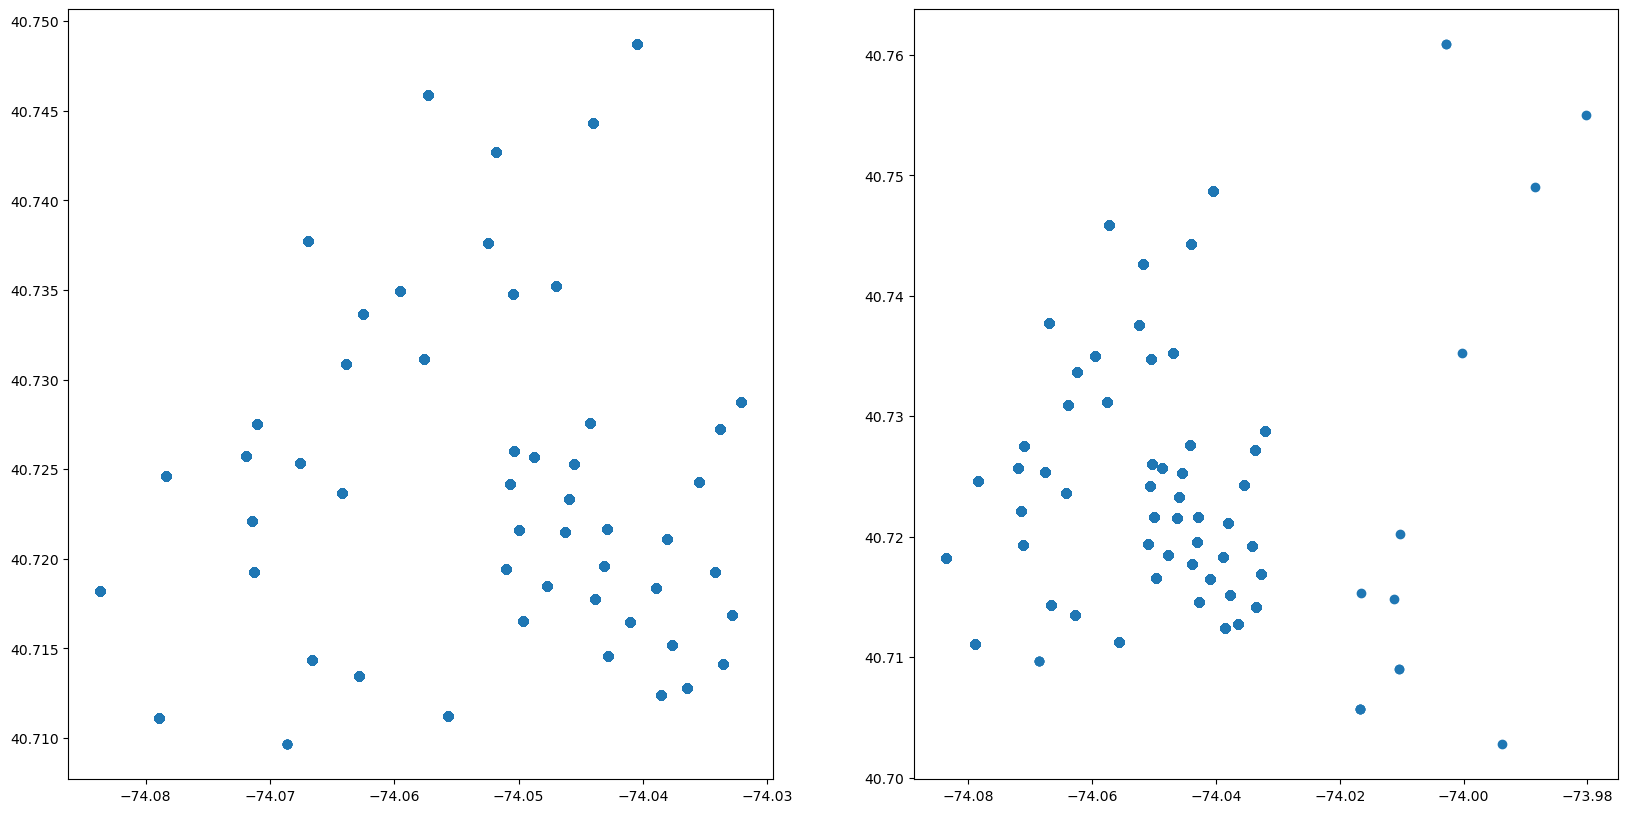

In [7]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(combined_data['start station longitude'], combined_data['start station latitude'])
ax = fig.add_subplot(1, 2, 2)
ax.scatter(combined_data['end station longitude'], combined_data['end station latitude'])

Next up, we'll have a look at a box plot and here we see a potential issue. Our data series are in very different ranges, with the first dimension (tripduration) dominating. If left unchecked, this will lead to the trip duration dominating our clustering.

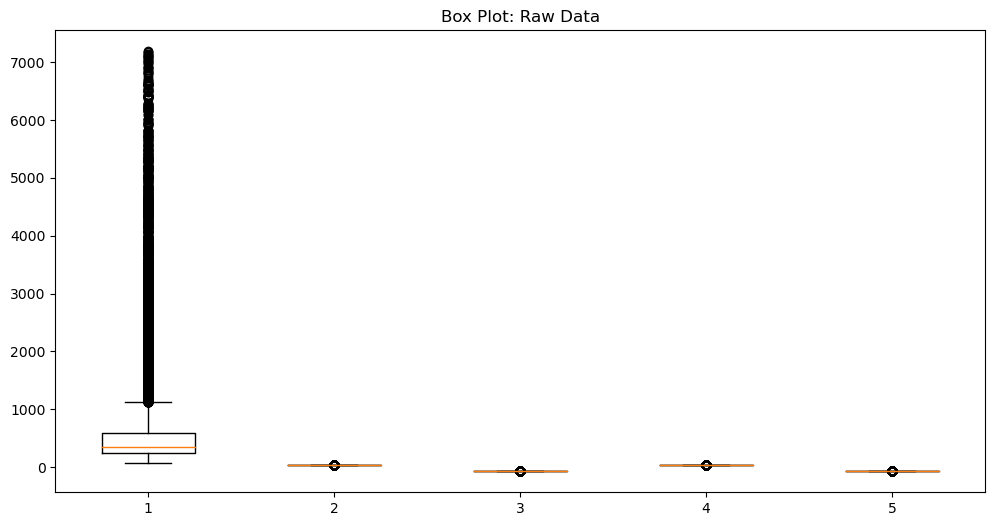

In [8]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(data_to_cluster)
ax.set_title('Box Plot: Raw Data');

As such, we'll standardise the data.

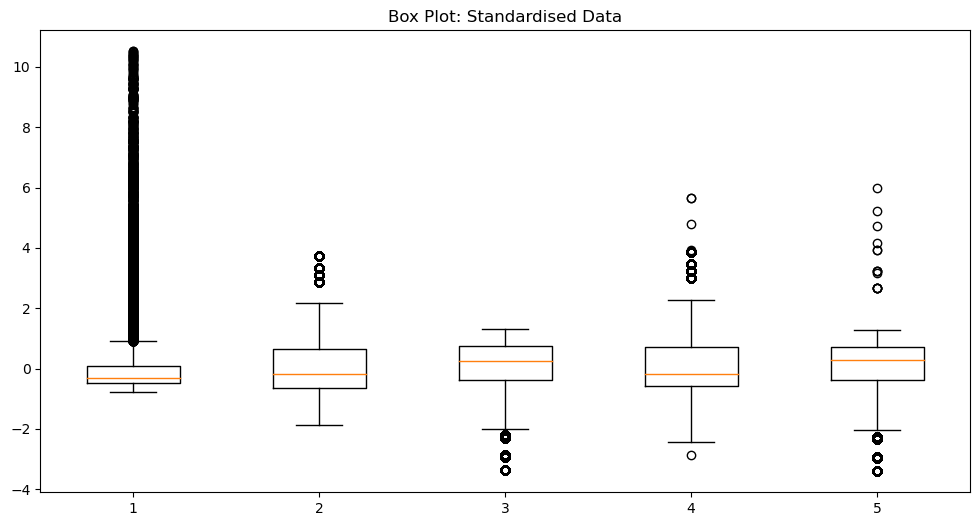

In [9]:
data_to_cluster_mu = numpy.mean(data_to_cluster, axis=0)
data_to_cluster_sigma = numpy.std(data_to_cluster, axis=0)
data_to_cluster_std = (data_to_cluster - data_to_cluster_mu)/data_to_cluster_sigma
data_to_cluster_jul20_std = (data_to_cluster_jul20 - data_to_cluster_mu)/data_to_cluster_sigma
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(data_to_cluster_std)
ax.set_title('Box Plot: Standardised Data');

## Application 1: Segmentation / Knowledge Discovery

We can now move onto our first application: Segmentation / Knowledge Discovery.

Before we can proceed, we need to come up with an estimate of K. We'll do that for K-means first.

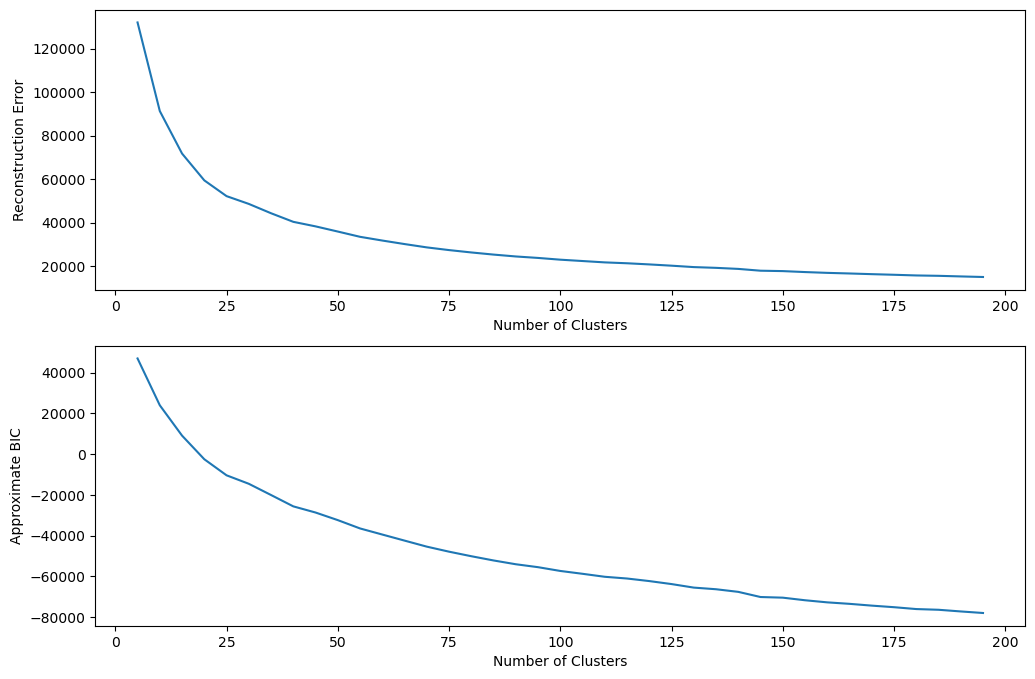

In [10]:
def compute_approximate_bic(kmeans, X):
    
    k = numpy.shape(kmeans.cluster_centers_)[0]*(numpy.shape(kmeans.cluster_centers_)[1] + 1)
    m = len(X)
    
    approx_bic = m*numpy.log(kmeans.inertia_ / m) + k*numpy.log(m)
    return approx_bic    

recon_error = []
bic = []
for i in range (5, 200, 5):
    kmeans = KMeans(n_clusters=(i+1), random_state=4, n_init='auto').fit(data_to_cluster_std)
    bic.append(compute_approximate_bic(kmeans, data_to_cluster_std))
    recon_error.append(kmeans.inertia_)

fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(range (5, 200, 5), recon_error)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Reconstruction Error');    
ax = fig.add_subplot(2, 1, 2)
ax.plot(range (5, 200, 5), bic)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Approximate BIC');    

From the above, the "elbow" method gives us a K of around 10, while the approximate BIC is yet to reach a minimum. 

Looking at the BIC for a GMM we get the following.

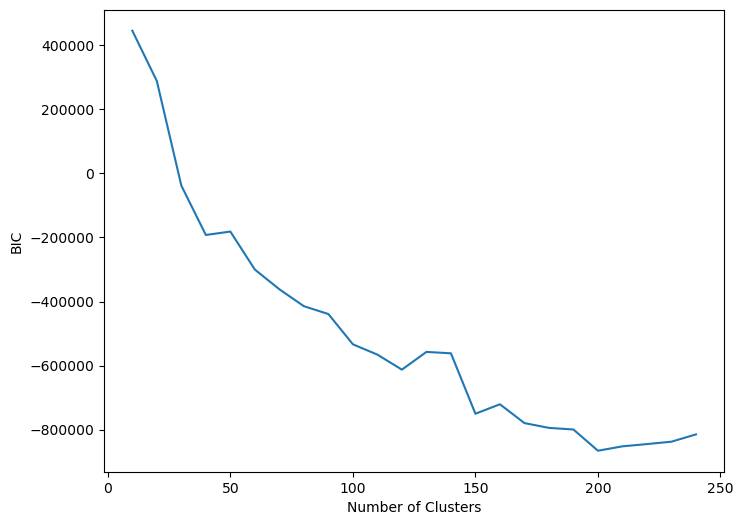

In [11]:
bics = []
for i in range (10, 250, 10):
    gmm = GaussianMixture(i+1, random_state=4)
    gmm.fit(data_to_cluster_std)
    bics.append(gmm.bic(data_to_cluster_std))
    
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(10, 250, 10), bics)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('BIC');

Maybe we have a minmum at about 200, however this could be noise too and we may not have quite bottomed out.

Considering our task, which is to group the data into related trips and analyse the cluster distributions, larger numbers of clusters will mean more fine-grained segmentation and more data to analyse. This is not necessarily a bad thing (particularly for a whole city where a large number of behaviours are possible), however for our task the ~200 cluster option is probably overkill. As such, we'll run with 10.

While methods such as these are helpful for selecting K, there is always scope to select a different value based on your own needs. In our case, the difficulties in visualising and analysing ~200 distinct clusters in a shortish python script make this value a little impractical. As such, we'll pick 10 which is (roughly) the elbow of the approximate BIC curve. We'll use this value for both K-means and our GMM.

### K-Means

We'll start with K-Means. Note we've defined $K$ below. If you wish to re-run this with a different value of $K$, you can simply change this value.

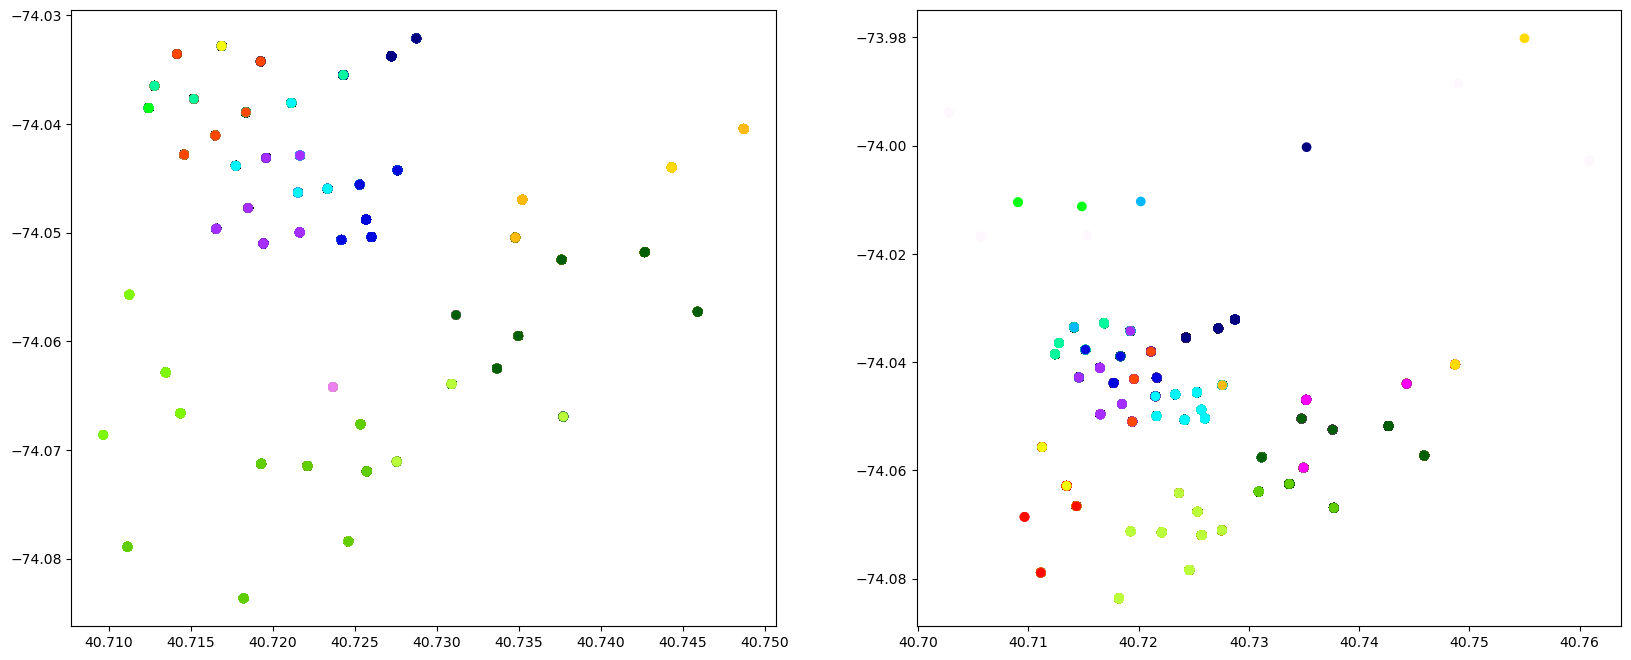

In [12]:
k = 20

kmeans = KMeans(n_clusters=k, random_state=4, n_init='auto').fit(data_to_cluster_std)
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(data_to_cluster[:,1], data_to_cluster[:,2], c=kmeans.labels_, cmap=cm.get_cmap('gist_ncar'));
ax = fig.add_subplot(1, 2, 2)
ax.scatter(data_to_cluster[:,3], data_to_cluster[:,4], c=kmeans.labels_, cmap=cm.get_cmap('gist_ncar'));

We can see our clusters are broadly capturing different patterns of movement, between groups of bike stations. Inspecting the cluster centres, we see that a couple of the clusters seem to correspond to long duration trips.

From this, we could also assign semantic labels/descriptions to each of these clusters. This is beyond the scope of this example (and my knowledge of New York geography).

In [13]:
scaled_centres = kmeans.cluster_centers_*data_to_cluster_sigma + data_to_cluster_mu
for i in range(k):
    print('Cluster Centre %d: %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' % (i, scaled_centres[i, 0], scaled_centres[i, 1], scaled_centres[i, 2], scaled_centres[i, 3], scaled_centres[i, 4]))

Cluster Centre 0: 374.95, 40.723, -74.037, 40.727, -74.035
Cluster Centre 1: 467.34, 40.736, -74.058, 40.737, -74.058
Cluster Centre 2: 374.41, 40.726, -74.044, 40.719, -74.041
Cluster Centre 3: 1840.76, 40.725, -74.039, 40.725, -74.039
Cluster Centre 4: 300.08, 40.721, -74.043, 40.726, -74.047
Cluster Centre 5: 296.13, 40.717, -74.038, 40.716, -74.036
Cluster Centre 6: 1565.80, 40.718, -74.040, 40.718, -74.040
Cluster Centre 7: 424.09, 40.723, -74.071, 40.731, -74.064
Cluster Centre 8: 659.12, 40.712, -74.061, 40.718, -74.043
Cluster Centre 9: 493.00, 40.730, -74.065, 40.723, -74.072
Cluster Centre 10: 5580.85, 40.719, -74.046, 40.720, -74.047
Cluster Centre 11: 763.63, 40.745, -74.046, 40.743, -74.047
Cluster Centre 12: 873.97, 40.741, -74.049, 40.723, -74.042
Cluster Centre 13: 404.92, 40.715, -74.038, 40.721, -74.043
Cluster Centre 14: 760.64, 40.718, -74.042, 40.715, -74.062
Cluster Centre 15: 1109.68, 40.722, -74.041, 40.739, -74.052
Cluster Centre 16: 264.13, 40.720, -74.046, 40

We can think of each cluster being a type of behaviour. As such, we can look at how often each cluster (behaviour) occurs as a way to capture overall usage patterns and look for changes in usage over time.

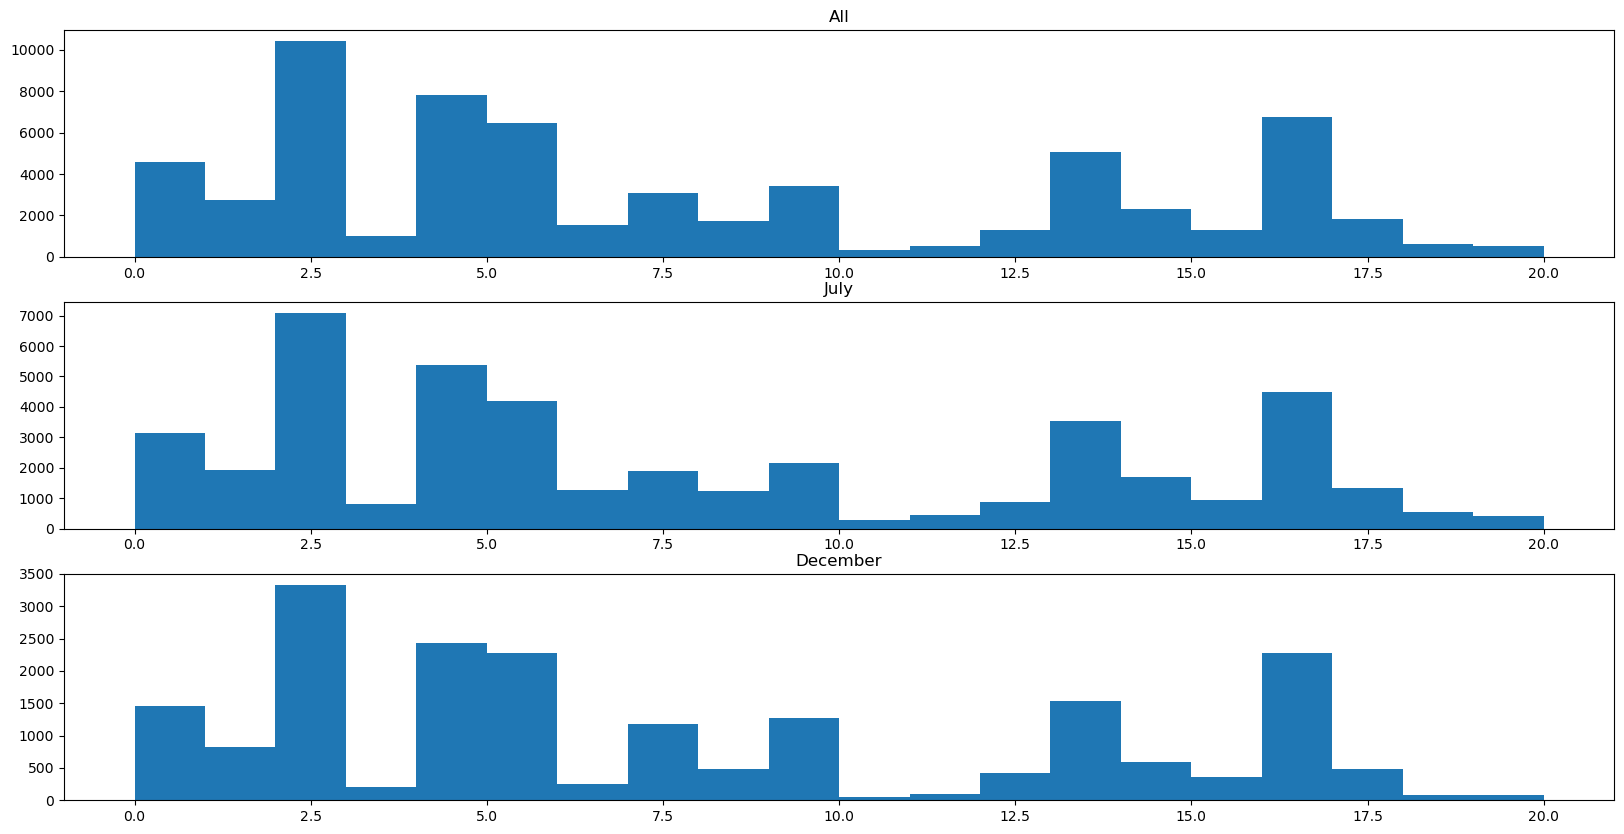

In [14]:
def draw_bars(labels, jul, dec, k):

    bins = list(range(k + 1))
    
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(3, 1, 1)
    ax.hist(labels, bins=bins)
    ax.set_title('All')
    ax = fig.add_subplot(3, 1, 2)
    ax.hist(jul, bins=bins)
    ax.set_title('July')
    ax = fig.add_subplot(3, 1, 3)
    ax.hist(dec, bins=bins)
    ax.set_title('December')
    
draw_bars(kmeans.labels_, kmeans.labels_[0:samples_jul_19], kmeans.labels_[samples_jul_19:], k)

Considering the usage for July and December 2019, we see little variation. All plots look fairly similar, suggesting that there is no major change in usage.

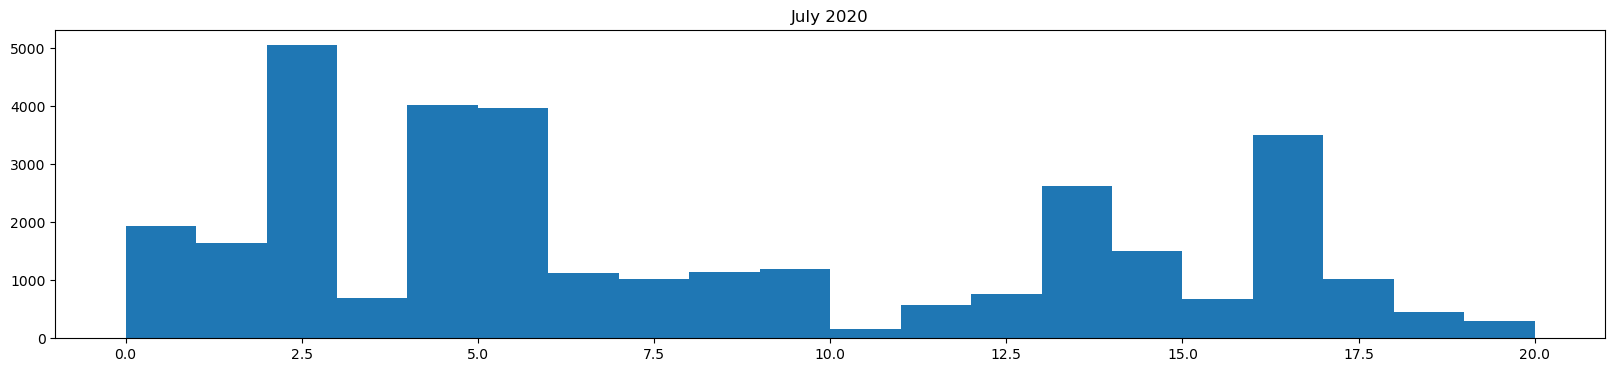

In [15]:
labels = kmeans.predict(data_to_cluster_jul20_std)
bins = list(range(k + 1))
fig = plt.figure(figsize=[20, 4])
ax = fig.add_subplot(1, 1, 1)
ax.hist(labels, bins=bins)
ax.set_title('July 2020');

Comparing July 2020 to the above plots, we again see pretty similar performance. There are some small changes, but on the whole performance is fairly similar.

A limitation of the above analysis is that it's quite subjective. It's based on manually inspecting these plots and so there is lots of scope for different people to interpret the data differently. To overcome this, we need a way to compare two histograms. There are a lot of possible approaches for this, but we'll use a fairly straight forward method which is the histogram intersection. To compute the histogram intersection we need to:
* Normalise the histograms, i.e. divide each bin of the histogram by the the sum of the histogram, such that the histogram sums to one
* To compare two histograms, sum the minimal value across each bin

For two histograms that are identical, the intersection will be 1. For two that are totally different, the intersection will be 0.

In [16]:
bin_counts_all, _ = numpy.histogram(kmeans.labels_, bins)
bin_counts_jul19, _ = numpy.histogram(kmeans.labels_[0:samples_jul_19], bins)
bin_counts_dec19, _ = numpy.histogram(kmeans.labels_[samples_jul_19:], bins)
bin_counts_jul20, _ = numpy.histogram(labels, bins)

def normalise_histogram(hist):
    return hist / numpy.sum(hist)

bin_counts_all = normalise_histogram(bin_counts_all)
bin_counts_jul19 = normalise_histogram(bin_counts_jul19)
bin_counts_dec19 = normalise_histogram(bin_counts_dec19)
bin_counts_jul20 = normalise_histogram(bin_counts_jul20)

def histogram_intersection(hist1, hist2):
    total = 0
    for i, j in zip(hist1, hist2):
        total += min(i, j)
    return total

print('All vs July\'19: %f' % (histogram_intersection(bin_counts_all, bin_counts_jul19)))
print('All vs Dec\'19:  %f' % (histogram_intersection(bin_counts_all, bin_counts_dec19)))
print('All vs July\'20: %f' % (histogram_intersection(bin_counts_all, bin_counts_jul20)))

All vs July'19: 0.976988
All vs Dec'19:  0.949146
All vs July'20: 0.929734


Computing the histogram intersections, we can see that we have on the whole very similar distributions; though July'20 does have a slightly greater change in behaviour than the others. This backs up what we could see from the plots, which is good.

While this (and other metrics) are good, there is no clear value as to at what point things become "too different". This is something that depends on the application and what is being investigated.

### GMM

We'll now move onto the GMM.

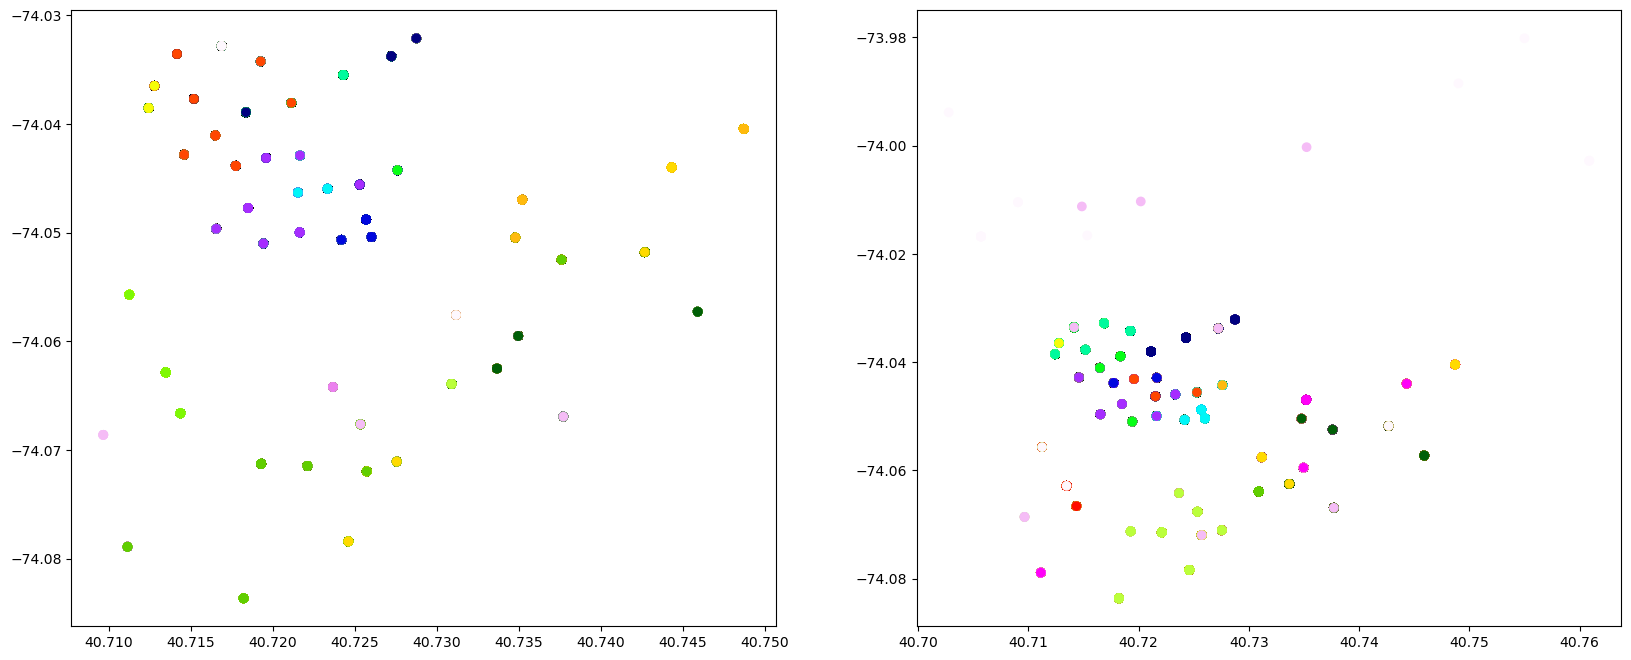

In [17]:
gmm = GaussianMixture(k, random_state=4)
gmm.fit(data_to_cluster_std)
labels = gmm.predict(data_to_cluster_std)
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(data_to_cluster[:,1], data_to_cluster[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
ax = fig.add_subplot(1, 2, 2)
ax.scatter(data_to_cluster[:,3], data_to_cluster[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));

Looking at the above, we can see that we have far more complex cluster boundaries than we had with the GMM. This is expected, as K-means will create spherical clusters, while with a GMM we can capture clusters of varying shapes and densities. In this case, we could argue that we are getting a much better representation of the data.

In [18]:
scaled_centres = gmm.means_*data_to_cluster_sigma + data_to_cluster_mu
for i in range(k):
    print('Cluster Centre %d: %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' % (i, scaled_centres[i, 0], scaled_centres[i, 1], scaled_centres[i, 2], scaled_centres[i, 3], scaled_centres[i, 4]))

Cluster Centre 0: 358.49, 40.721, -74.039, 40.726, -74.035
Cluster Centre 1: 382.99, 40.736, -74.058, 40.737, -74.058
Cluster Centre 2: 275.61, 40.726, -74.045, 40.720, -74.042
Cluster Centre 3: 430.75, 40.722, -74.040, 40.727, -74.046
Cluster Centre 4: 230.08, 40.720, -74.044, 40.725, -74.048
Cluster Centre 5: 320.00, 40.719, -74.040, 40.716, -74.035
Cluster Centre 6: 658.03, 40.723, -74.039, 40.718, -74.042
Cluster Centre 7: 401.09, 40.725, -74.069, 40.731, -74.064
Cluster Centre 8: 594.87, 40.712, -74.059, 40.718, -74.044
Cluster Centre 9: 381.19, 40.730, -74.064, 40.723, -74.072
Cluster Centre 10: 1755.24, 40.721, -74.046, 40.721, -74.046
Cluster Centre 11: 697.42, 40.736, -74.059, 40.734, -74.059
Cluster Centre 12: 774.23, 40.739, -74.049, 40.722, -74.042
Cluster Centre 13: 290.56, 40.716, -74.038, 40.719, -74.043
Cluster Centre 14: 708.12, 40.719, -74.041, 40.712, -74.059
Cluster Centre 15: 970.59, 40.721, -74.041, 40.733, -74.059
Cluster Centre 16: 215.35, 40.720, -74.046, 40.71

Analysing our histograms, we are seeing similar trends in 2019, i.e. behaviours don't change much between July and December.

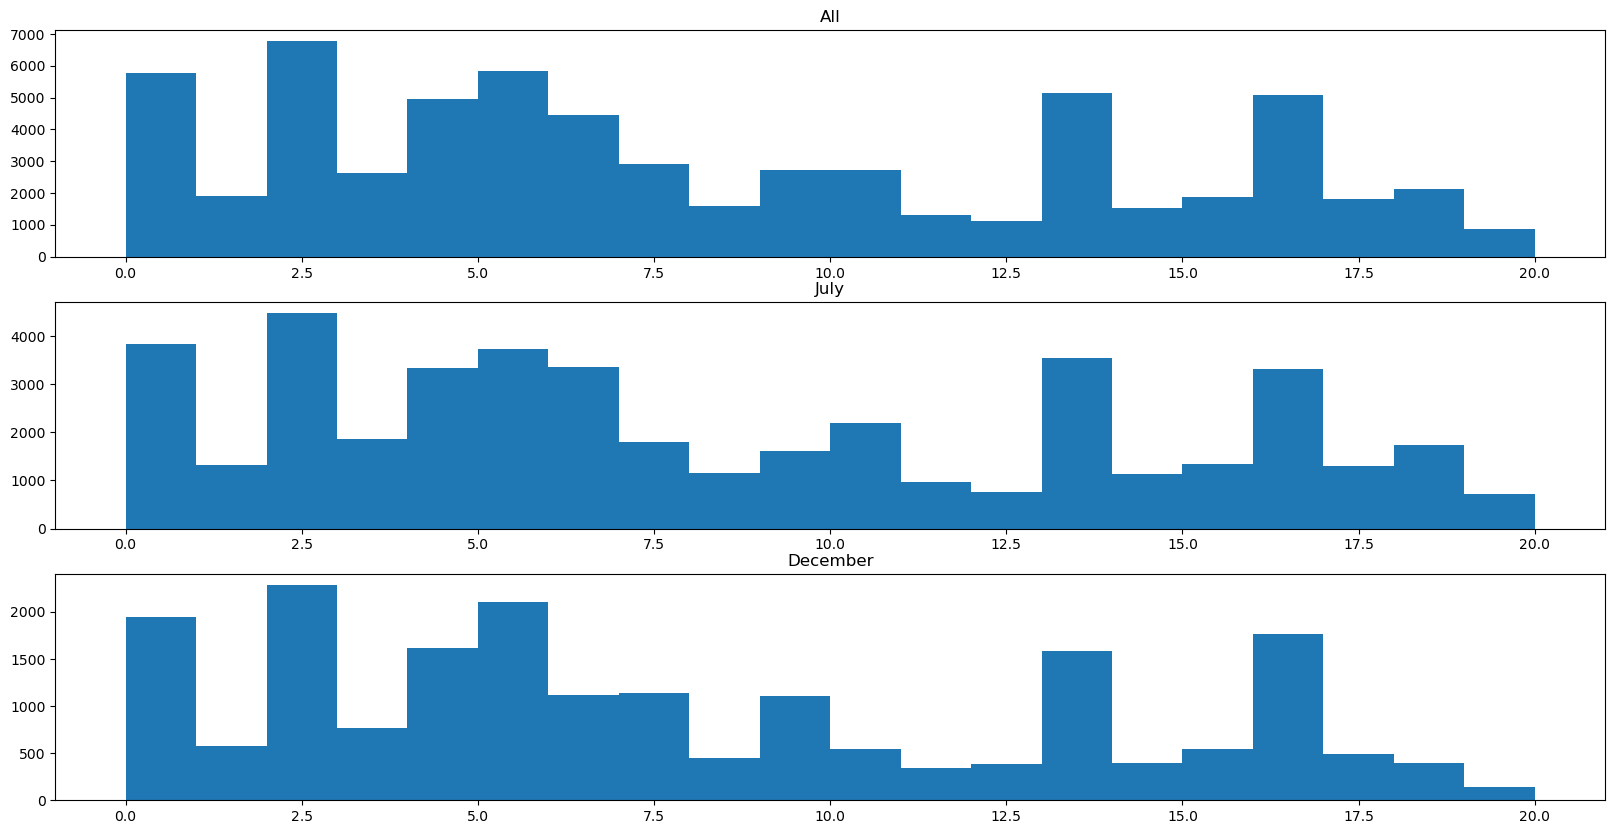

In [19]:
draw_bars(labels, labels[0:samples_jul_19], labels[samples_jul_19:], k)

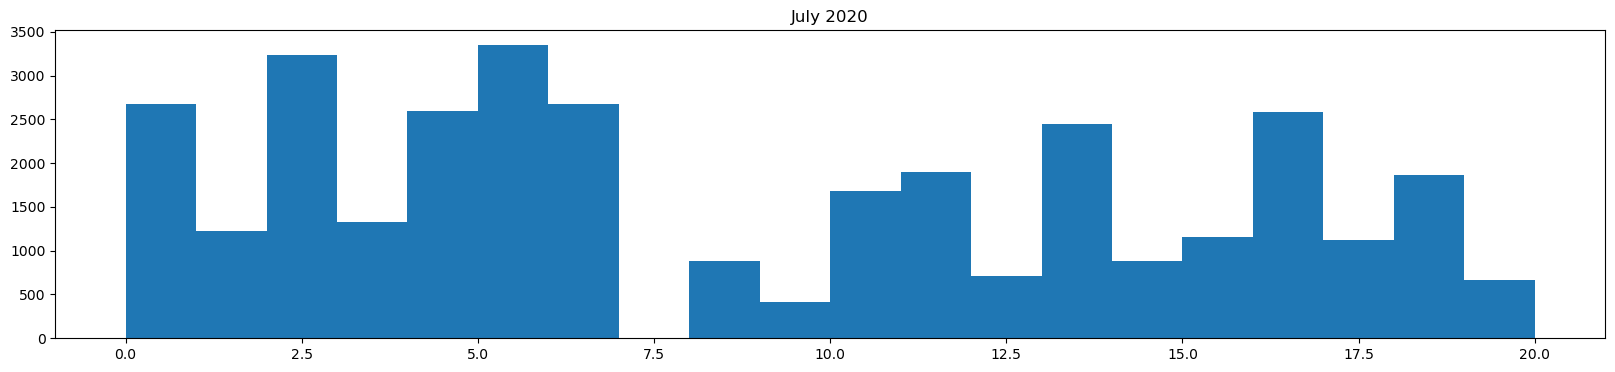

In [20]:
labels_jul20 = gmm.predict(data_to_cluster_jul20_std)
bins = list(range(k + 1))
fig = plt.figure(figsize=[20, 4])
ax = fig.add_subplot(1, 1, 1)
ax.hist(labels_jul20, bins=bins)
ax.set_title('July 2020');

We do however see a much larger change between our 2019 data and the July 2020 sample, in particular cluster 7 vanishes.

In [21]:
bin_counts_all, _ = numpy.histogram(labels, bins)
bin_counts_jul19, _ = numpy.histogram(labels[0:samples_jul_19], bins)
bin_counts_dec19, _ = numpy.histogram(labels[samples_jul_19:], bins)
bin_counts_jul20, _ = numpy.histogram(labels_jul20, bins)

bin_counts_all = normalise_histogram(bin_counts_all)
bin_counts_jul19 = normalise_histogram(bin_counts_jul19)
bin_counts_dec19 = normalise_histogram(bin_counts_dec19)
bin_counts_jul20 = normalise_histogram(bin_counts_jul20)

print('All vs July\'19: %f' % (histogram_intersection(bin_counts_all, bin_counts_jul19)))
print('All vs Dec\'19:  %f' % (histogram_intersection(bin_counts_all, bin_counts_dec19)))
print('All vs July\'20: %f' % (histogram_intersection(bin_counts_all, bin_counts_jul20)))

All vs July'19: 0.968617
All vs Dec'19:  0.930645
All vs July'20: 0.887559


That visual change is reflected in the histogram intersection, where we see a drop in similarity between July'20 and the other data. 

### Further Thoughts

With this application, we'd see different results if:
* we re-run with a different number of clusters
* we change the random seed

Changing the random seed should lead to minor variations - for the most part we'd expect this will lead to clusters being "swapped" (i.e. clusters 1 and 2 being swapped, but being close to the same), with just small changes around boundary points.

Increasing the number of clusters will allow the analysis of more fine-grained behaviours, and will help to identify fine-grained differences in the data. However as we add more and more clusters, it becomes harder to assign semantic meaning to them all, and we may find that we end up over-clustering the data (i.e. having two or more clusters that capture the same underlying behaviour).

## Application 2: Anomaly Detection

Let's move onto our second application, anomaly detection.

The standard setup for anomly detection is to train on normal data, and then look at how well a point fits the model learned on normal data. To do this, we need to define a threshold for what constitues an abnormal point. Usually, to do this we'd have:
* A training set with normal data only to learn the model
* A validation set with some known abnormal points to learn the optimal threshold
* A testing set, to test the model

We'll take a slightly different approach we have no labels for any points. We'll decide that 0.05% of points should be abnormal, and find the most unusual 0.05% of points.

In [22]:
abnormal_amount = 0.0005;
abnormal_count = int(len(data_to_cluster_jul20_std)*(1.0 - abnormal_amount))
abnormal_samples = len(data_to_cluster_jul20_std) - abnormal_count
print(abnormal_samples)

17


For our data, this means that we're looking at the weirdest 17 bike trips.

### K-Means

Let's start with K-means. We'll use the same model we had above with 20 clusters.

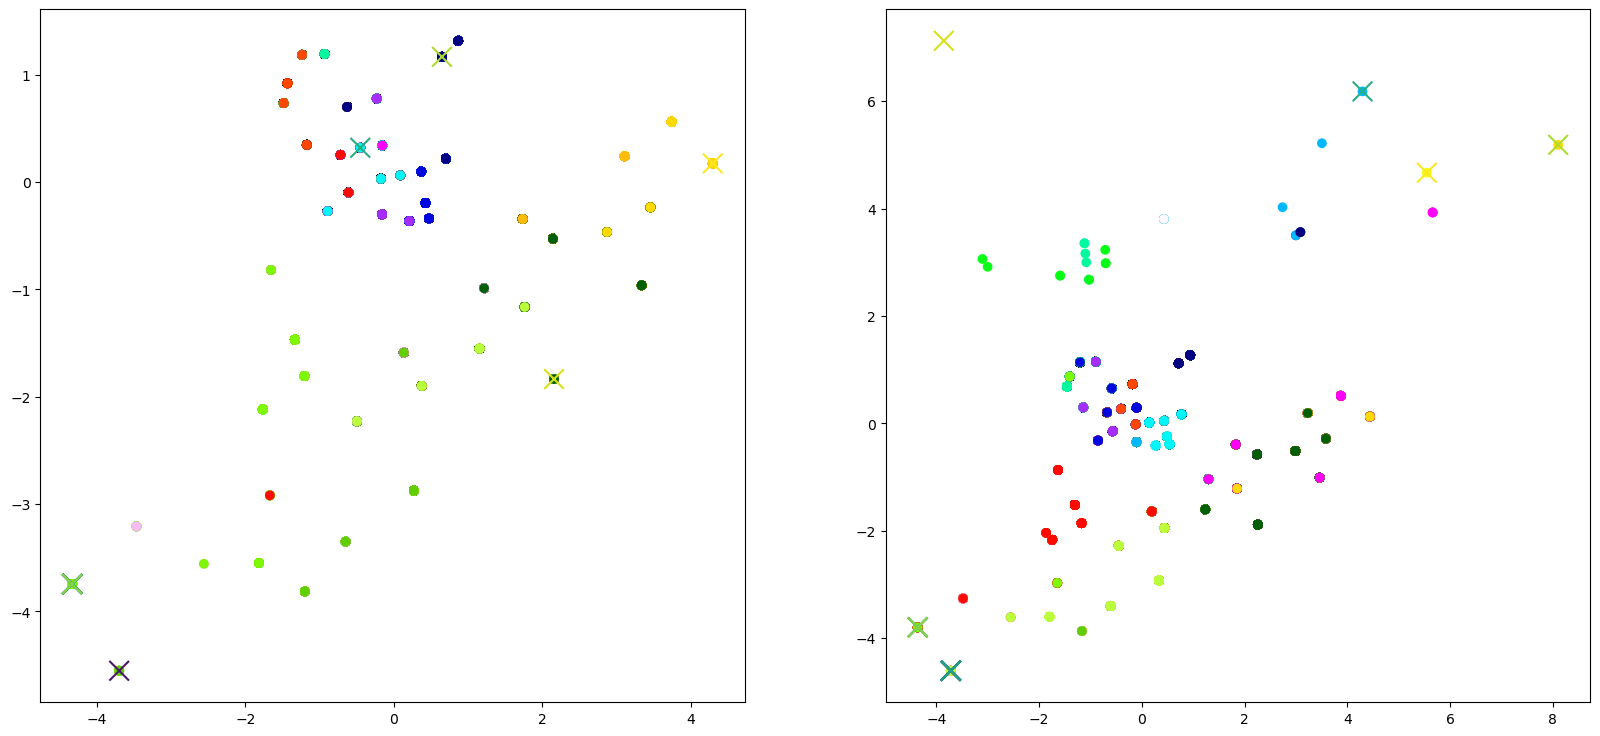

In [23]:
labels = kmeans.predict(data_to_cluster_jul20_std)
distances = kmeans.transform(data_to_cluster_jul20_std)
distances = numpy.min(distances, axis=1)
sorted_distances = numpy.argsort(distances)

fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(data_to_cluster_jul20_std[:,1], data_to_cluster_jul20_std[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
ax.scatter(data_to_cluster_jul20_std[sorted_distances[abnormal_count:],1], data_to_cluster_jul20_std[sorted_distances[abnormal_count:],2], marker='x', s=200, c=range(abnormal_samples))

ax = fig.add_subplot(1, 2, 2)
ax.scatter(data_to_cluster_jul20_std[:,3], data_to_cluster_jul20_std[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));
ax.scatter(data_to_cluster_jul20_std[sorted_distances[abnormal_count:],3], data_to_cluster_jul20_std[sorted_distances[abnormal_count:],4], marker='x', s=200, c=range(abnormal_samples))

We can visualise all the clusters and where the abnormalities exist in the above plot, which is a little bit hard to see.

As such, below we visualise the five most unusual points.

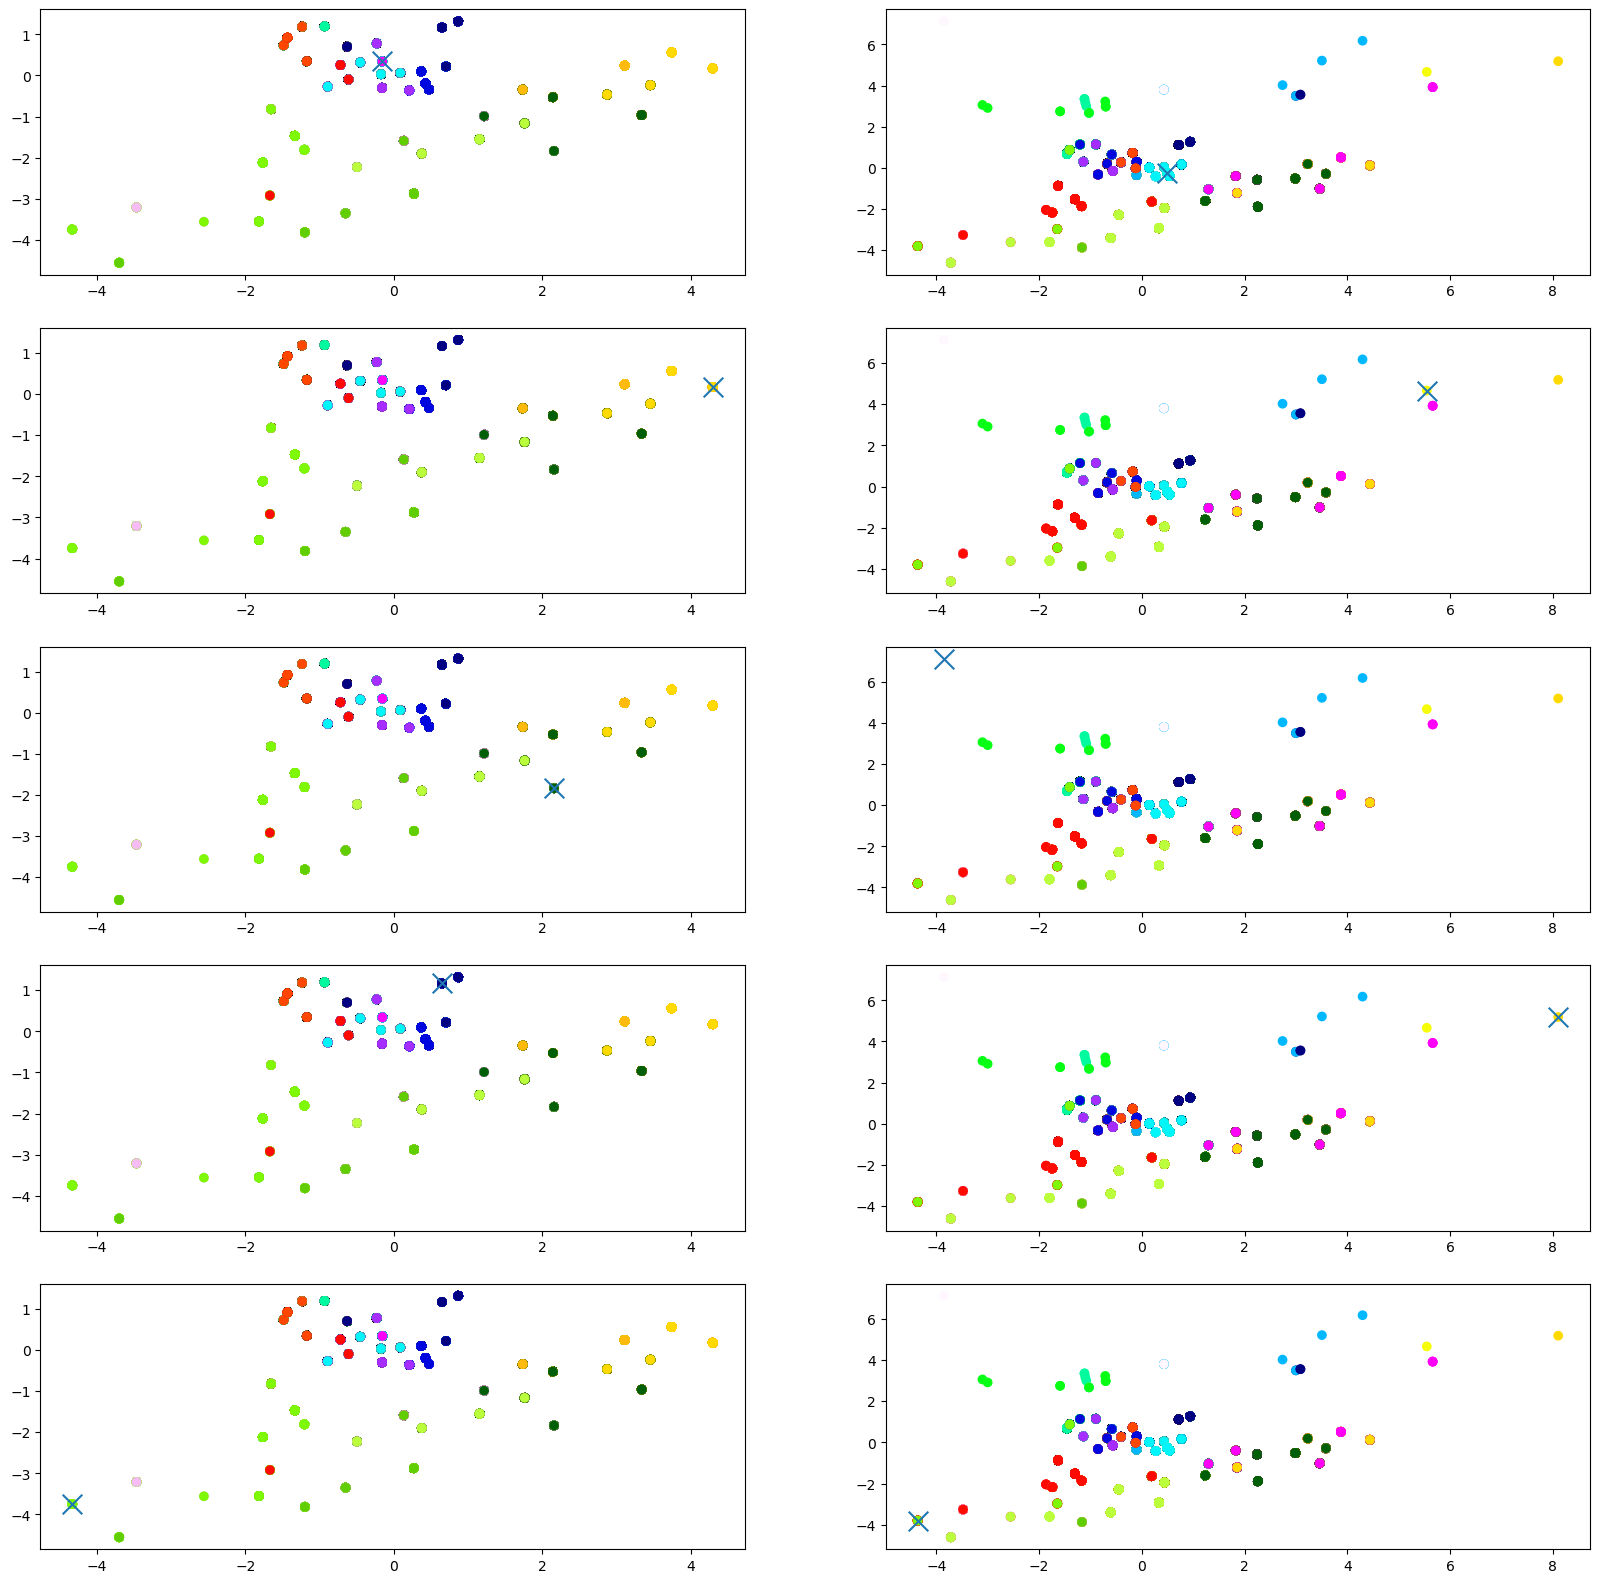

In [24]:
fig = plt.figure(figsize=[20, 20])
for i in range(5):
    ax = fig.add_subplot(5, 2, i*2 + 1)
    ax.scatter(data_to_cluster_jul20_std[:,1], data_to_cluster_jul20_std[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
    ax.scatter(data_to_cluster_jul20_std[sorted_distances[-i],1], data_to_cluster_jul20_std[sorted_distances[-i],2], marker='x', s=200)

    ax = fig.add_subplot(5, 2, (i+1)*2)
    ax.scatter(data_to_cluster_jul20_std[:,3], data_to_cluster_jul20_std[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));
    ax.scatter(data_to_cluster_jul20_std[sorted_distances[-i],3], data_to_cluster_jul20_std[sorted_distances[-i],4], marker='x', s=200)

Considering the above, and the abnormal point details below (consider the last 5, these are the "most" abnormal), we see that the most abnormal points are all trips that are very long. 

We see that these points mostly belong to cluster 6, which itself is a cluster that tends to capture the long trips. Some points are long trips that go a long way, others are long trips that go not very far at all. 

Other points in our model abnormal set seem to exist at cluster boundaries, rather than explicitly being outliers. This is really a result of how we are finding abnormal points. We don't have a measure of likelihood, what we have is distance to the assigned cluster centre. If a point lies in the middle of two clusters, it may be a long way from a cluster centre (whilst not being that unusual), and so may come back as being "unusual" with this measure.

In [25]:
scaled_centres = kmeans.cluster_centers_*data_to_cluster_sigma + data_to_cluster_mu
for i in range(k):
    print('Cluster Centre %d: %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' % (i, scaled_centres[i, 0], scaled_centres[i, 1], scaled_centres[i, 2], scaled_centres[i, 3], scaled_centres[i, 4]))

print('')

scaled_samples = data_to_cluster_jul20_std[sorted_distances[abnormal_count:], :]*data_to_cluster_sigma + data_to_cluster_mu
abnormal_labels = labels[sorted_distances[abnormal_count:]]
for i in range(abnormal_samples):
    print('Abnormal Sample %d (Cluster %d): %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' \
          % (i, abnormal_labels[i], scaled_samples[i, 0], scaled_samples[i, 1], scaled_samples[i, 2], \
             scaled_samples[i, 3], scaled_samples[i, 4]))

Cluster Centre 0: 374.95, 40.723, -74.037, 40.727, -74.035
Cluster Centre 1: 467.34, 40.736, -74.058, 40.737, -74.058
Cluster Centre 2: 374.41, 40.726, -74.044, 40.719, -74.041
Cluster Centre 3: 1840.76, 40.725, -74.039, 40.725, -74.039
Cluster Centre 4: 300.08, 40.721, -74.043, 40.726, -74.047
Cluster Centre 5: 296.13, 40.717, -74.038, 40.716, -74.036
Cluster Centre 6: 1565.80, 40.718, -74.040, 40.718, -74.040
Cluster Centre 7: 424.09, 40.723, -74.071, 40.731, -74.064
Cluster Centre 8: 659.12, 40.712, -74.061, 40.718, -74.043
Cluster Centre 9: 493.00, 40.730, -74.065, 40.723, -74.072
Cluster Centre 10: 5580.85, 40.719, -74.046, 40.720, -74.047
Cluster Centre 11: 763.63, 40.745, -74.046, 40.743, -74.047
Cluster Centre 12: 873.97, 40.741, -74.049, 40.723, -74.042
Cluster Centre 13: 404.92, 40.715, -74.038, 40.721, -74.043
Cluster Centre 14: 760.64, 40.718, -74.042, 40.715, -74.062
Cluster Centre 15: 1109.68, 40.722, -74.041, 40.739, -74.052
Cluster Centre 16: 264.13, 40.720, -74.046, 40

### GMM

We'll move onto the GMM now. As per K-means, we're using the same GMM we trained earlier.

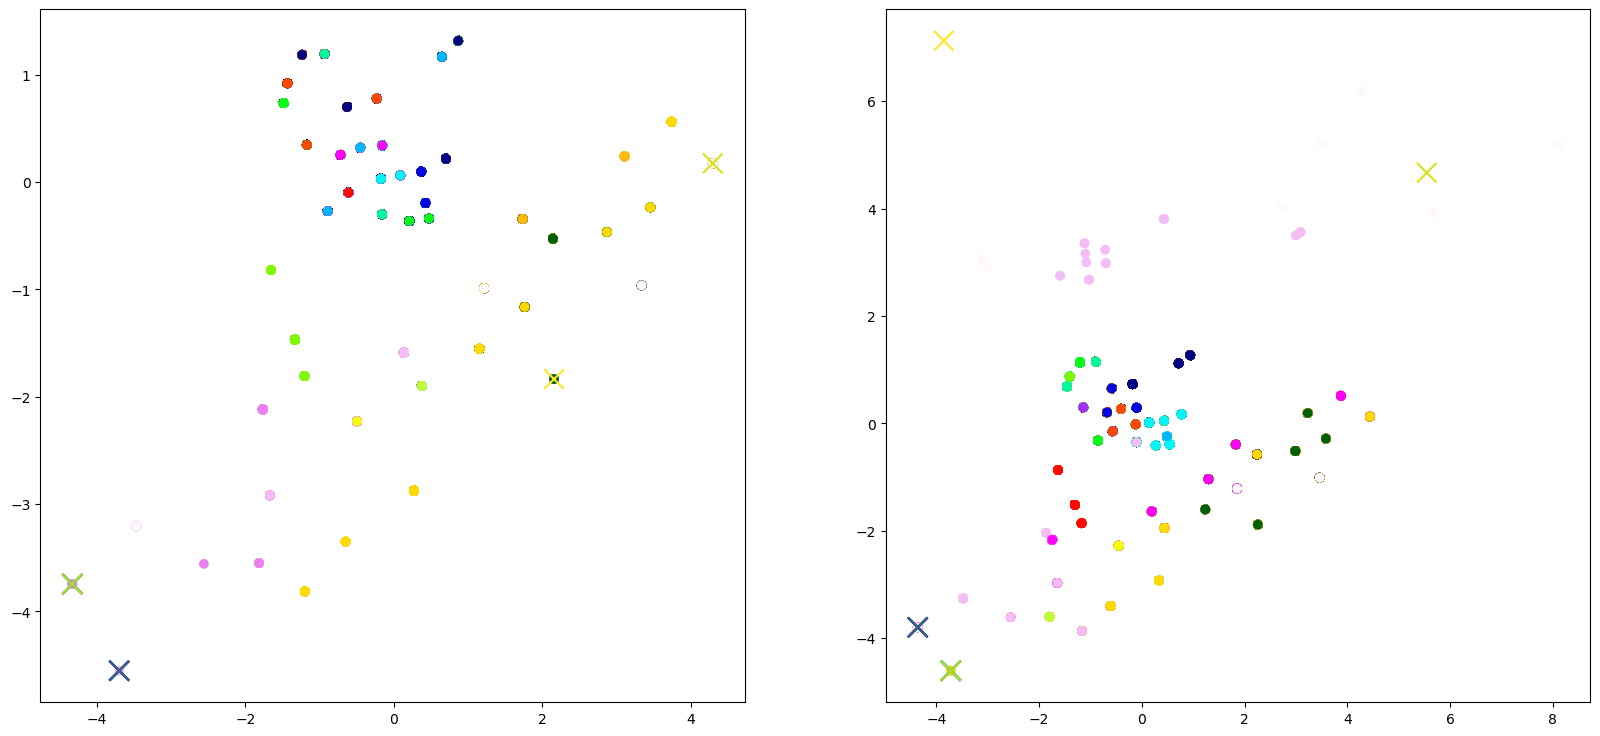

In [26]:
labels = gmm.predict(data_to_cluster_jul20_std)
scores = gmm.score_samples(data_to_cluster_jul20_std)
sorted_scores = numpy.flip(numpy.argsort(scores))

fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(data_to_cluster_jul20_std[:,1], data_to_cluster_jul20_std[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
ax.scatter(data_to_cluster_jul20_std[sorted_scores[abnormal_count:],1], data_to_cluster_jul20_std[sorted_scores[abnormal_count:],2], marker='x', s=200, c=range(abnormal_samples))

ax = fig.add_subplot(1, 2, 2)
ax.scatter(data_to_cluster_jul20_std[:,3], data_to_cluster_jul20_std[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));
ax.scatter(data_to_cluster_jul20_std[sorted_scores[abnormal_count:],3], data_to_cluster_jul20_std[sorted_scores[abnormal_count:],4], marker='x', s=200, c=range(abnormal_samples))

Similar to K-means, we'll look at the five most unusual points in isolation.

Again, we see that our most abnormal points are dominated by the trip duration, but others are capturing more unusual paths with fairly normal durations, which suggests that we're doing a better job of capturing trips that go in an unusual direction.

Perhaps of concern, all of our unusual points belong to one cluster (19), which suggests that perhaps our clustering is sub-optimal, or at least this cluster should be more closely investigated.

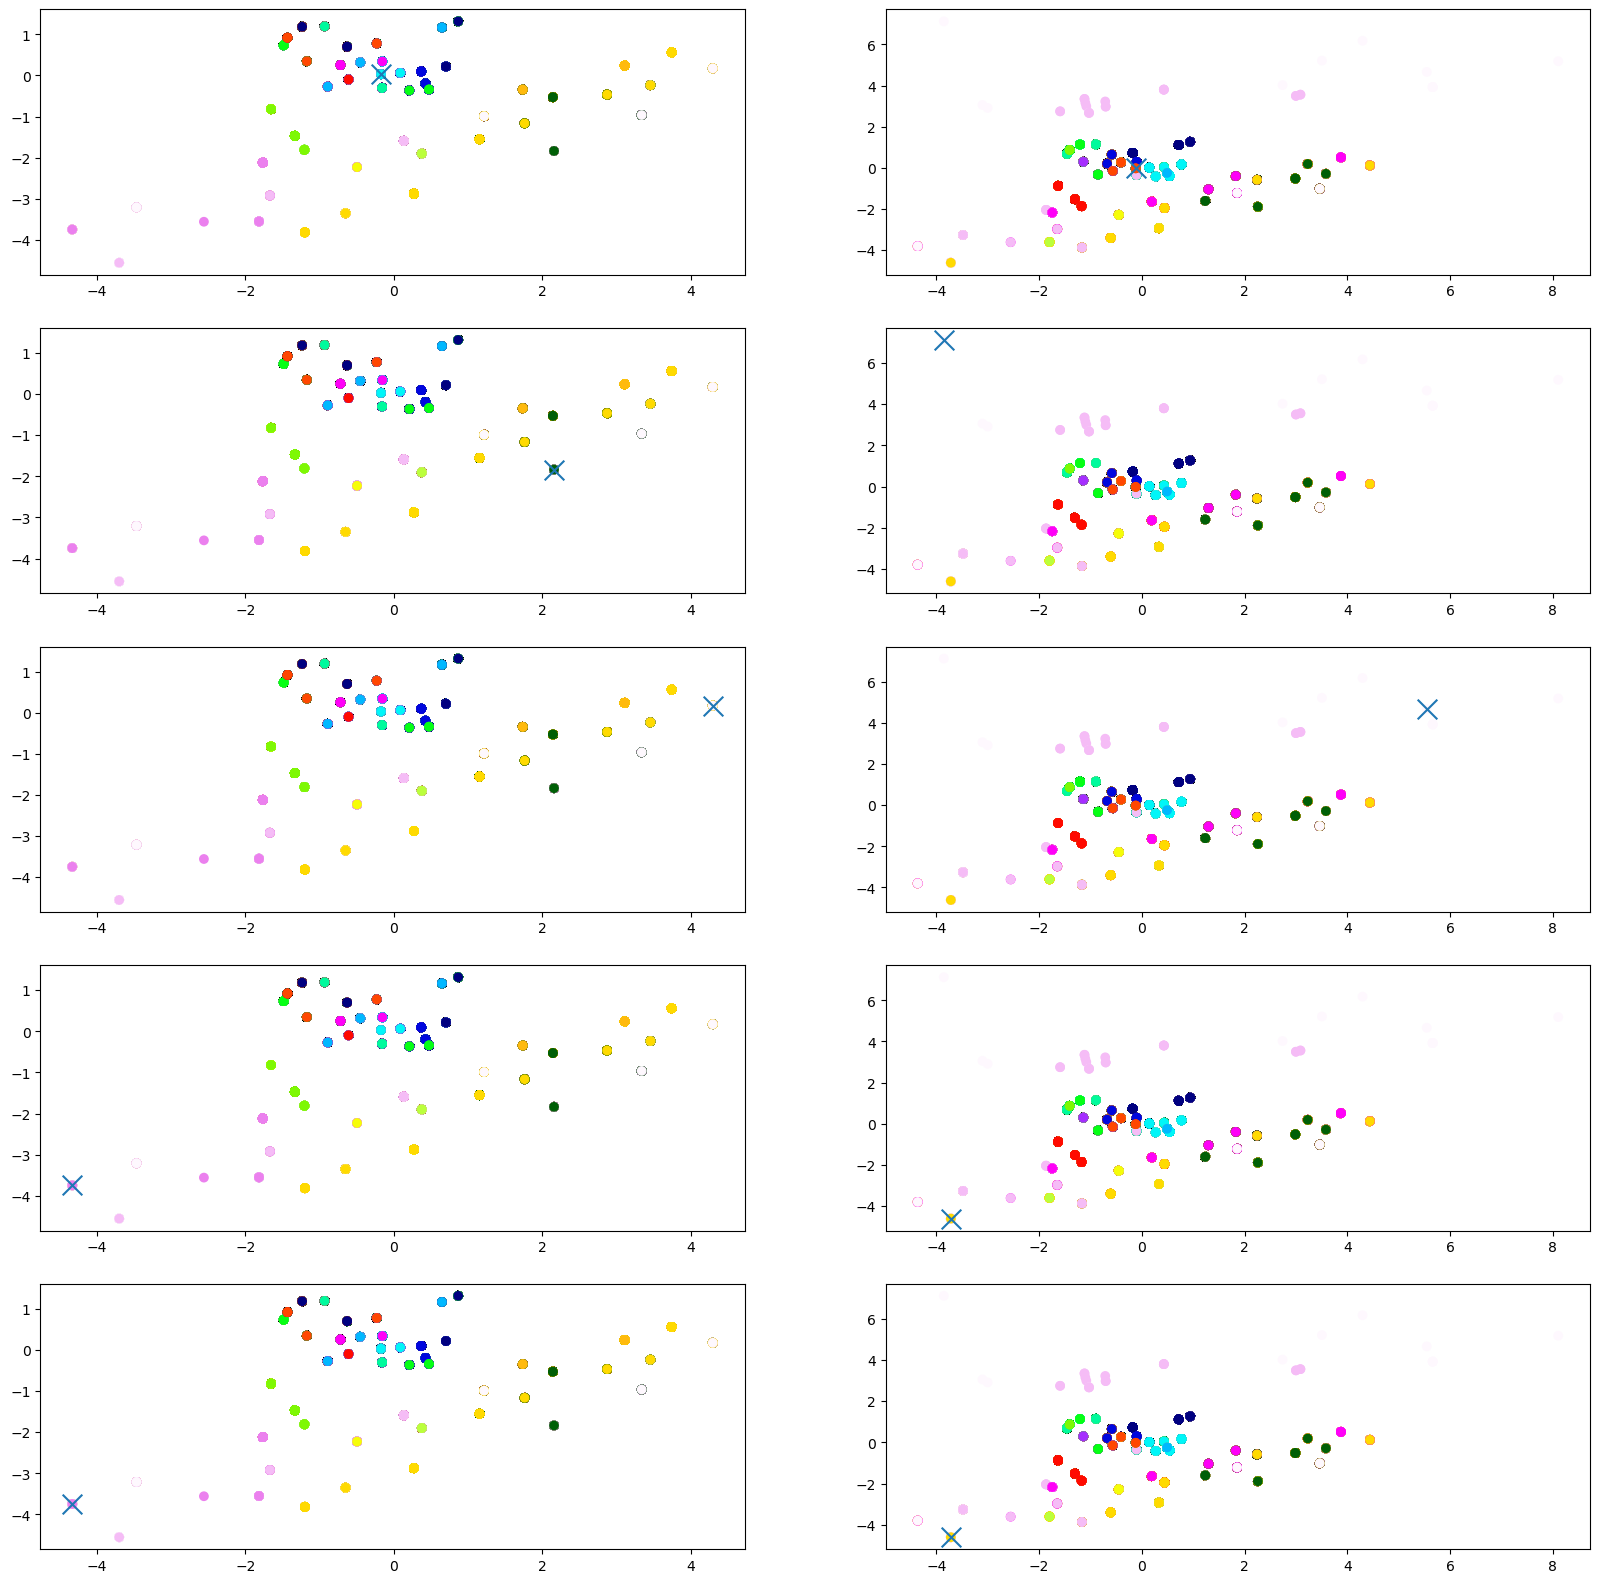

In [27]:
fig = plt.figure(figsize=[20, 20])
for i in range(5):
    ax = fig.add_subplot(5, 2, i*2 + 1)
    ax.scatter(data_to_cluster_jul20_std[:,1], data_to_cluster_jul20_std[:,2], c=labels, cmap=cm.get_cmap('gist_ncar'));
    ax.scatter(data_to_cluster_jul20_std[sorted_scores[-i],1], data_to_cluster_jul20_std[sorted_scores[-i],2], marker='x', s=200)

    ax = fig.add_subplot(5, 2, (i+1)*2)
    ax.scatter(data_to_cluster_jul20_std[:,3], data_to_cluster_jul20_std[:,4], c=labels, cmap=cm.get_cmap('gist_ncar'));
    ax.scatter(data_to_cluster_jul20_std[sorted_scores[-i],3], data_to_cluster_jul20_std[sorted_scores[-i],4], marker='x', s=200)

In [28]:
scaled_centres = gmm.means_*data_to_cluster_sigma + data_to_cluster_mu
for i in range(k):
    print('Cluster Centre %d: %1.2f, %1.3f, %1.3f, %1.3f, %1.3f' % (i, scaled_centres[i, 0], scaled_centres[i, 1], scaled_centres[i, 2], scaled_centres[i, 3], scaled_centres[i, 4]))

print('')

scaled_samples = data_to_cluster_jul20_std[sorted_scores[abnormal_count:], :]*data_to_cluster_sigma + data_to_cluster_mu
abnormal_labels = labels[sorted_scores[abnormal_count:]]
for i in range(abnormal_samples):
    print('Abnormal Sample %d (Cluster %d): %1.2f, %1.3f, %1.3f, %1.3f, %1.3f; likelihood: %f' \
          % (i, abnormal_labels[i], scaled_samples[i, 0], scaled_samples[i, 1], scaled_samples[i, 2], \
             scaled_samples[i, 3], scaled_samples[i, 4], scores[sorted_scores[abnormal_count + i]]))

Cluster Centre 0: 358.49, 40.721, -74.039, 40.726, -74.035
Cluster Centre 1: 382.99, 40.736, -74.058, 40.737, -74.058
Cluster Centre 2: 275.61, 40.726, -74.045, 40.720, -74.042
Cluster Centre 3: 430.75, 40.722, -74.040, 40.727, -74.046
Cluster Centre 4: 230.08, 40.720, -74.044, 40.725, -74.048
Cluster Centre 5: 320.00, 40.719, -74.040, 40.716, -74.035
Cluster Centre 6: 658.03, 40.723, -74.039, 40.718, -74.042
Cluster Centre 7: 401.09, 40.725, -74.069, 40.731, -74.064
Cluster Centre 8: 594.87, 40.712, -74.059, 40.718, -74.044
Cluster Centre 9: 381.19, 40.730, -74.064, 40.723, -74.072
Cluster Centre 10: 1755.24, 40.721, -74.046, 40.721, -74.046
Cluster Centre 11: 697.42, 40.736, -74.059, 40.734, -74.059
Cluster Centre 12: 774.23, 40.739, -74.049, 40.722, -74.042
Cluster Centre 13: 290.56, 40.716, -74.038, 40.719, -74.043
Cluster Centre 14: 708.12, 40.719, -74.041, 40.712, -74.059
Cluster Centre 15: 970.59, 40.721, -74.041, 40.733, -74.059
Cluster Centre 16: 215.35, 40.720, -74.046, 40.71

Perhaps the nicest thing we get with the GMM is we get the likelihood (negative log likelihood), where a smaller value indicates more abnormal.

One odd thing we see is that all the abnormal points belong to cluster 19. Further inspection shows that they are all farily confidently assigned to cluster 19 as well.

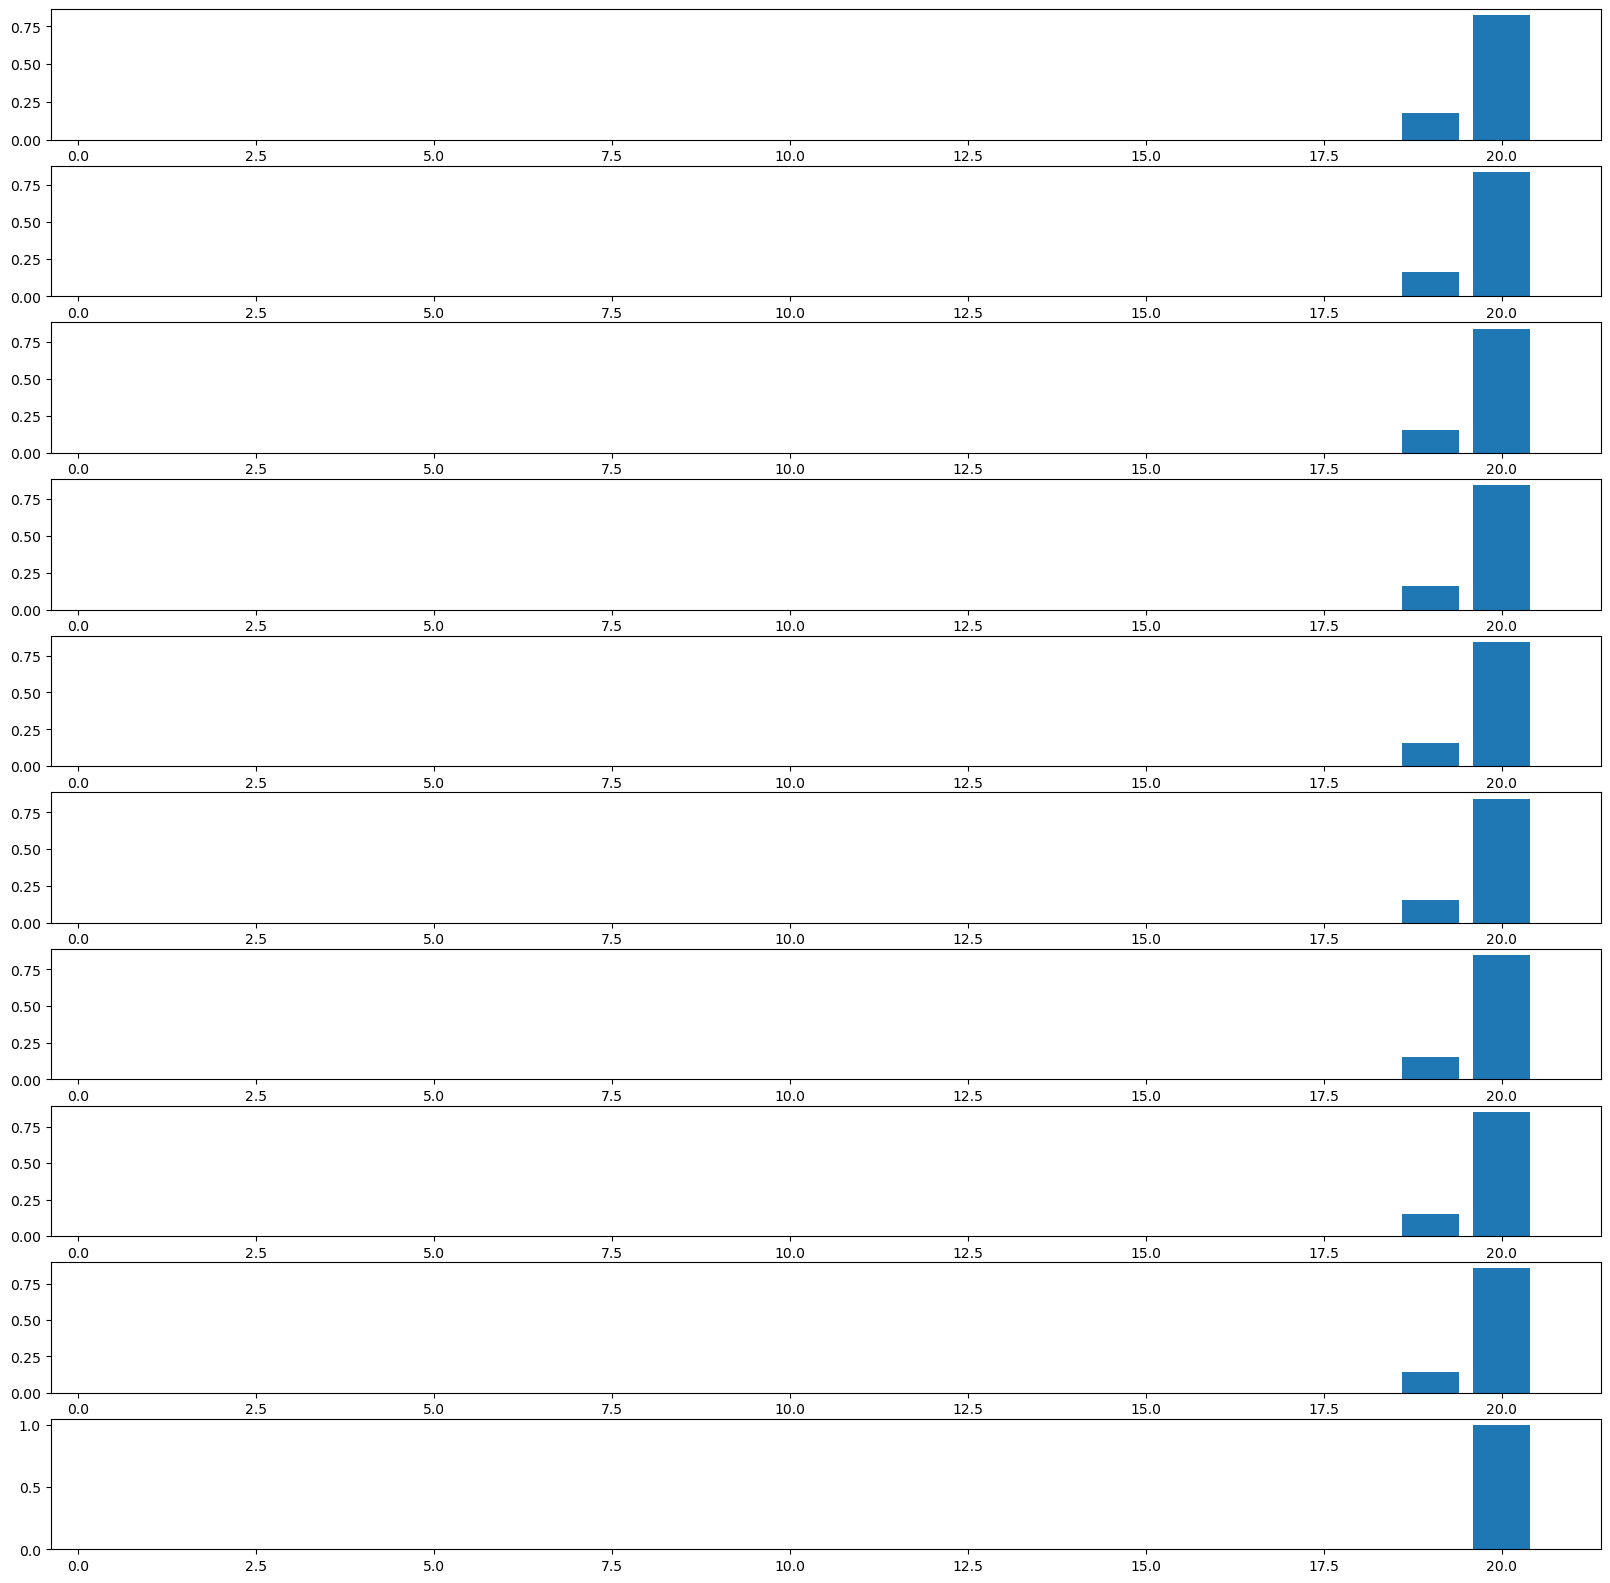

In [29]:
posterior = gmm.predict_proba(data_to_cluster_jul20_std[sorted_scores[-11:-1], :])
fig = plt.figure(figsize=[20, 20])
for i in range(10):
    ax = fig.add_subplot(10, 1, i+1)
    ax.bar(range(1,21), posterior[i,:])

This is not necessarily wrong, but would metrit further investigation. It may just be a quirk of the random seed, or it may be down to us not having enough clusters to properly describe the data, and thus having cluster 19 as a large cluster that trying to capture too many things, and ultimatley not capturing any one thing properly.

## Final Thoughts

In this example we've considered two applications of clustering:
* Knowledge discovery
* Anomaly detection

We've use both K-Means and GMMs for this, and both have worked to a point. On the whole, the GMM offers us a bit more flexibility in this data due to:
* The ability to capture various size and shaped clusters, which allows us to better model the data
* The ability to pull out likelihood values gives us a more meaninful way to identify abnormal points

That said, our GMM is much more computationally demanding to train, which while ok on this dataset (though getting the BIC curve is very slow), could become a problem as dataset size increases further (for example, if we had a whole year of data). 

It's also worth noting that as we change the number of clusters, we'll get very different results. In particular, using more clusters. You are encouraged to re-run this with different numbers of clusters (I'd recommend commenting out the blocks that plot reconstruction error and BIC) and seeing what changes.